# Plate solve

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from scipy.interpolate import interp1d, PchipInterpolator
from sklearn.linear_model import LinearRegression
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS

from image_data import ImageData
from ui.histogram_plot import calc_stretch
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder

import skymap.platesolver as PS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project

### Load and visualize image

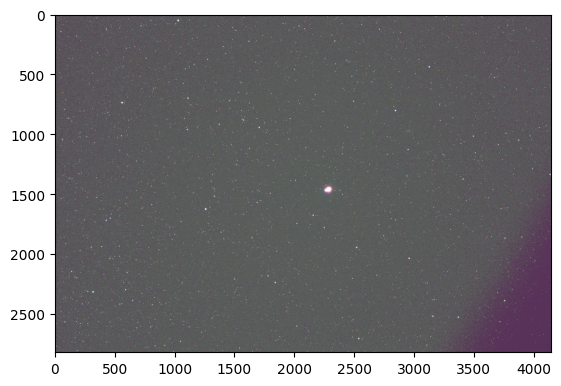

In [20]:
imageData = ImageData(raw=None, fname=r"C:\images\plate-solving-samples\Albereo\Light_03239_10.0sec_120gain_21.1C.fit", header=None)
def stretch(imageData):
    hr, hg, hb = imageData.get_deb16_histogram()
    a,b = calc_stretch(hr, hg, hb)
    gamma_table = np.zeros((256, 3), dtype=np.uint8)
    for i in range(3):
        high = max(a[i], b[i])
        low = min(a[i], b[i])
        spline = PchipInterpolator([0, low, high, 256], [0, 0, 255, 256])
        gamma_table[:, i] = spline(np.arange(256))
    r = cv2.LUT(imageData.rgb24[:, :, 0], gamma_table[:, 0])
    g = cv2.LUT(imageData.rgb24[:, :, 1], gamma_table[:, 1])
    b = cv2.LUT(imageData.rgb24[:, :, 2], gamma_table[:, 2])
    img_stretched = cv2.cvtColor(np.stack([r, g, b], axis=-1), cv2.COLOR_BGR2RGB)
    return img_stretched
img_stretched = stretch(imageData)
plt.imshow(img_stretched)

### Set rough location


In [21]:
center = SkyCoord.from_name("Albereo")
result = {
    'solved': False
}

### Stars selected from the image (tgt)

- Top 20 stars are selected by magnitude

fitgaussian2d on 20 images took 0.07 sec; avg: 0.003577 sec
Num tgt stars: 19


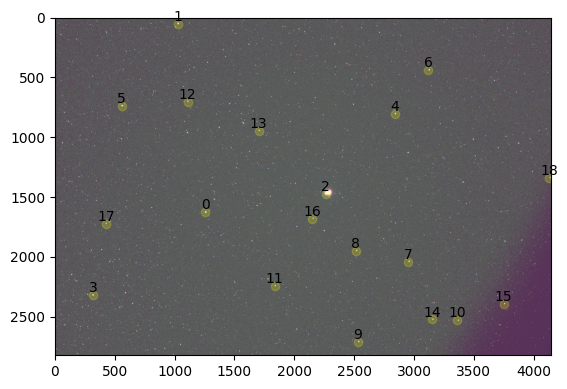

In [22]:
df_tgt = imageData.stars
print(f"Num tgt stars: {len(df_tgt)}")
result['num_tgt'] = len(df_tgt)

plt.imshow(img_stretched, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2, color='yellow')
for idx, tgt in df_tgt.iterrows():
  plt.text(tgt.cluster_cx, tgt.cluster_cy, idx, va='bottom', ha='center', c='black')
plt.show()


### Stars selected from the database (ref)

Cone search and retrieve stars in the neighborhood

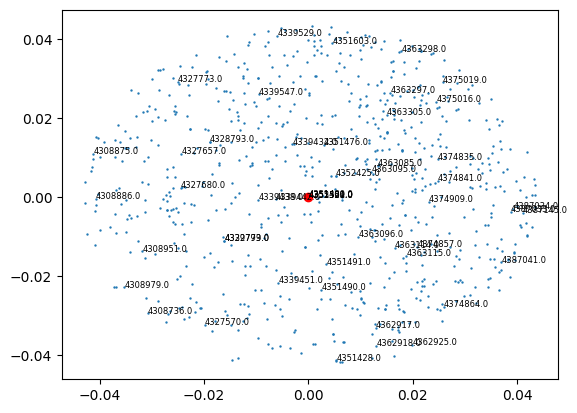

Num ref stars: 783


,id,cluster_cx,cluster_cy,ra,dec,mag
0,4351509,3.158142e-07,1.126106e-07,292.680335,27.959680,3.156923
1,4352321,6.678153e-07,7.237118e-08,292.680358,27.959678,3.736250
2,4327773,-2.501177e-02,2.916614e-02,291.031577,29.621336,4.844222
3,4351480,1.362057e-04,9.776298e-05,292.689151,27.965275,5.030000
4,4308736,-3.080108e-02,-2.937048e-02,290.712023,26.262408,5.076111


In [23]:
with SkyMap() as sm:
    df_ref = PS.cone_search_stardata(sm, center, fov_deg=5.0, mag_limit=11.0)

plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy, s=0.5)
for i in range(min(50,len(df_ref))):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')
plt.show()

print(f"Num ref stars: {len(df_ref)}")
result['num_ref'] = len(df_ref)
display(df_ref.head())

### Match stars in image to database, produce a transform matrix

Transformation matrix captures scale (zoom), translation (position) and rotation of telescope

In [24]:
matcher = StarMatcher()
matcher_result = matcher.matchStars(
    df_ref, df_tgt,
    vertex_sorted = True,
    down_votes = True,
    absolute_similar = True,
    vote_with_conf = True,
    limit_ref_triangle_fov = None)
# tx, matcher_result = matcher.matchStarsToTx(df_ref, df_tgt, limit_ref_triangle_fov=1.0)
print(matcher_result)

{'vertex_sorted': True, 'down_votes': True, 'absolute_similar': True, 'vote_with_conf': True, 'limit_ref_triangle_fov': None, 'ref_triangles': 2196, 'tgt_triangles': 969, 'triangle_tolerance': 0.002349707978292458, 'triangle_comparisons': 2127924, 'total_votes': np.float32(-1.4901161e-07), 'hit_ratio': np.float32(-7.0026755e-14), 'votes': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.49999884, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32), 'vVotingPairs': array([[21,  0

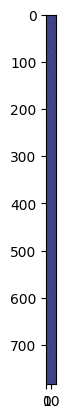

In [25]:
plt.imshow(matcher_result['votes'])

In [26]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
21,4352425,0.005293,0.005368,293.024645,28.266795,1256.531469,1627.979021,5.999753
3,4351480,0.000136,0.000098,292.689151,27.965275,2261.043860,1470.798246,4.999886
22,4351476,0.002975,0.013225,292.874703,28.717278,558.954023,739.448276,3.999806
88,4351481,0.000582,-0.006379,292.717917,27.594171,2952.943662,2038.549296,3.999799
132,4351483,0.001889,-0.003418,292.802620,27.763784,2515.000000,1948.400000,1.99985
114,4351514,0.006306,-0.006715,293.087934,27.574326,2532.500000,2708.500000,2.999821
69,4351516,0.006479,-0.000637,293.100421,27.922539,1836.444444,2241.555556,2.999885
80,4351474,0.000444,0.010144,292.709288,28.540899,1108.444444,701.555556,2.999872
92,4351477,-0.000608,0.005607,292.640733,28.280905,1702.000000,946.500000,1.999871


In [27]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
21,4352425,0.005293,0.005368,293.024645,28.266795,1256.531469,1627.979021,5.999753
3,4351480,0.000136,0.000098,292.689151,27.965275,2261.043860,1470.798246,4.999886
22,4351476,0.002975,0.013225,292.874703,28.717278,558.954023,739.448276,3.999806


In [28]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [29]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[ -79957.94000747 -112370.27711207    2282.92032461]
 [ 112221.13364383  -79985.98326351    1463.33272812]]


### Apply transform to database stars to map them to image frame

In [30]:
result.update(matcher_result)
result['tx'] = tx
df_ref[['img_cx', 'img_cy']] = df_ref.apply(lambda r: pd.Series(np.dot(tx, [r.cluster_cx, r.cluster_cy, 1])).astype(np.int32), axis=1)

display(df_ref)

,id,cluster_cx,cluster_cy,ra,dec,mag,img_cx,img_cy
0,4351509,3.158142e-07,1.126106e-07,292.680335,27.959680,3.156923,2282,1463
1,4352321,6.678153e-07,7.237118e-08,292.680358,27.959678,3.736250,2282,1463
2,4327773,-2.501177e-02,2.916614e-02,291.031577,29.621336,4.844222,1005,-3676
3,4351480,1.362057e-04,9.776298e-05,292.689151,27.965275,5.030000,2261,1470
4,4308736,-3.080108e-02,-2.937048e-02,290.712023,26.262408,5.076111,8046,356
...,...,...,...,...,...,...,...,...
778,4339591,-1.212719e-02,2.359314e-02,291.883449,29.309321,10.987500,601,-1784
779,4351758,5.161699e-03,3.988669e-02,293.022661,30.245205,10.990000,-2611,-1147
780,4327780,-1.613620e-02,2.677072e-02,291.618112,29.489687,10.990000,564,-2488
781,4339628,-8.355712e-03,3.815276e-02,292.126686,30.145111,10.997500,-1336,-2526


### Transformed database stars in image frame

- Graph below shows all the database stars considered, spanning 5 deg of sky
- Rectangle shows the region of stars captured in the image.
- Database stars falling in image can be used to find precise ra and dec of image center.

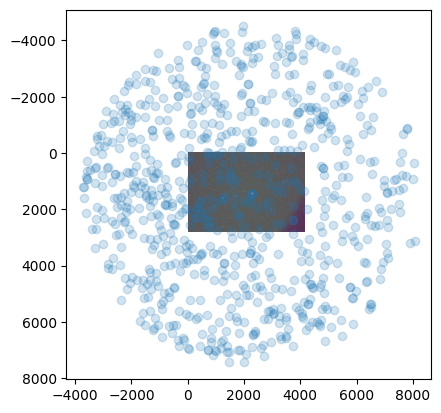

In [31]:
plt.imshow(img_stretched)
plt.scatter(df_ref.img_cx, df_ref.img_cy, alpha=0.2)

### Assign RA & DEC to stars in image

In [32]:
# Reassign stars
def dist(x1,y1, x2,y2):
    return np.sqrt((y2-y1)**2+(x2-x1)**2)

def reassign(t):
    x = df_ref.apply(lambda r: pd.Series([dist(t.cluster_cx, t.cluster_cy, r.img_cx, r.img_cy)]), axis=1)[0]
    m = x.min()
    if m < 25:
      idx = x.argmin()
      return pd.Series([idx, df_ref.iloc[idx].ra, df_ref.iloc[idx].dec])
    else:
      return pd.Series([None, None, None])

df_tgt[['starno', 'ra', 'dec']] = df_tgt.apply(reassign, axis=1)

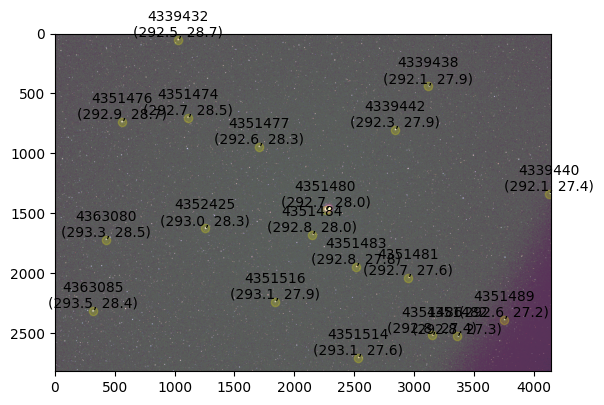

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,ra,dec
0,143,1256.531469,1627.979021,11.000977,13.000977,13.932695,12.803132,"[1244, 1614, 1269, 1641]",421966,6669,4.190299,4.645925,21.0,5.999753,293.024645,28.266795
1,122,1027.008197,53.352459,10.000977,11.000977,12.595748,11.159830,"[1016, 41, 1039, 66]",13725,292,3.994328,3.609852,35.0,None,292.481643,28.724298
2,114,2261.043860,1470.798246,11.000977,10.000977,11.621071,10.718655,"[2250, 1459, 2273, 1482]",381813,6051,6.435248,6.125417,3.0,4.999886,292.689151,27.965275
3,104,317.000000,2319.336538,10.000977,10.000977,9.983531,11.449505,"[306, 2309, 329, 2330]",600959,9370,3.743795,3.593149,29.0,None,293.547847,28.415650
4,93,2838.537634,805.376344,9.000977,9.000977,10.441028,10.079898,"[2828, 795, 2849, 816]",208946,3339,3.652045,3.058073,39.0,None,292.276374,27.929612
5,87,558.954023,739.448276,9.000977,9.000977,10.435764,10.096489,"[549, 729, 568, 750]",191800,3007,3.823654,3.636459,22.0,3.999806,292.874703,28.717278
6,79,3120.455696,440.443038,7.000977,9.000977,10.730360,7.669137,"[3112, 430, 3129, 451]",114740,1918,3.511873,3.153618,40.0,None,292.060116,27.921472
7,71,2952.943662,2038.549296,9.000977,8.000977,8.458252,9.108390,"[2943, 2030, 2962, 2047]",529098,8412,3.109179,3.159041,88.0,3.999799,292.717917,27.594171
8,70,2515.000000,1948.400000,8.000977,7.000977,8.360113,8.718994,"[2506, 1940, 2525, 1957]",505161,8009,3.072569,3.292849,132.0,1.99985,292.802620,27.763784
9,64,2532.500000,2708.500000,8.000977,8.000977,8.286255,8.291673,"[2524, 2700, 2541, 2717]",702005,11129,3.134373,2.885432,114.0,2.999821,293.087934,27.574326


In [33]:
plt.imshow(img_stretched, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2, color='yellow')
for idx, tgt in df_tgt[df_tgt.ra.notna()].iterrows():
    label = f"{df_ref[df_ref.index==tgt.starno].id.values[0]}\n({tgt.ra:.1f}, {tgt.dec:.1f})"
    plt.text(tgt.cluster_cx, tgt.cluster_cy, label, va='bottom', ha='center', c='black')
plt.show()

display(df_tgt[df_tgt.ra.notna()])

### Regress RA DEC of image center

In [34]:
nonantgt = df_tgt[ (~df_tgt.ra.isna()) & (~df_tgt.dec.isna())]
X = nonantgt[['cluster_cx', 'cluster_cy']]
y = nonantgt[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict(pd.DataFrame([{"cluster_cx": imageData.rgb24.shape[1]//2, "cluster_cy": imageData.rgb24.shape[0]//2}]))[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
separation_arcmin = center.separation(pred_center).arcminute
result['center'] = pred_center
result['separation_arcmin'] = separation_arcmin
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (292.71830145, 28.04322707)>
Separation from target: 5.402026619366123


In [35]:
if center.separation(pred_center).arcminute <= 20:
    
    result['solved'] = True

    df_tgt['name'] = None
    for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
        df_tgt.loc[idx, 'name'] = df_ref.loc[star.starno].id
display(result)

{'solved': True,
 'num_tgt': 19,
 'num_ref': 783,
 'vertex_sorted': True,
 'down_votes': True,
 'absolute_similar': True,
 'vote_with_conf': True,
 'limit_ref_triangle_fov': None,
 'ref_triangles': 2196,
 'tgt_triangles': 969,
 'triangle_tolerance': 0.002349707978292458,
 'triangle_comparisons': 2127924,
 'total_votes': np.float32(-1.4901161e-07),
 'hit_ratio': np.float32(-7.0026755e-14),
 'votes': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.49999884, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          

### In one-step:

In [36]:
PS.platesolve(imageData, center)

{'solved': True,
 'num_ref': 783,
 'num_tgt': 19,
 'vertex_sorted': True,
 'limit_ref_triangle_fov': 1.0,
 'ref_triangles': 2114,
 'tgt_triangles': 969,
 'matches': 13,
 'tx': array([[ -80134.9224376 , -112311.98137788,    2282.93873146],
        [ 111867.63969553,  -80053.69083562,    1463.3874953 ]]),
 'center': <SkyCoord (ICRS): (ra, dec) in deg
     (292.71830145, 28.04322707)>,
 'separation_arcmin': np.float64(5.402026619366123)}